In [18]:
using Gmsh, TipiFEM, TipiFEM.Meshes, TipiFEM.PolytopalMesh, TipiFEM.Quadrature
using StaticArrays
using PyPlot

# Load msh

In [19]:
msh = Gmsh.load("./assets/quad.msh", mesh_dim=2, world_dim=2)

INFO: Gmsh: reading 1601 nodes
INFO: Gmsh: reading 1668 elements


TipiFEM.Mesh at Ptr{Void} @0x00007ff85a8cbb80
  world dim: 2
  mesh dimension: 2
  cell types: Polytope"3-node triangle", Polytope"4-node quadrangle"
   Codim    Dim     #cells
       0      2       1536
       1      1       3136
       2      0       1601
  topology: 
    → | 0  1  2
    --|--------
    0 | 0  0  0     
    1 | 1  0  0     
    2 | 1  1  1

# Setup Finite Element space

In [20]:
basis = FEBasis{:Lagrangian, 1}()
dofh=TipiFEM.DofHandler(msh, basis) # todo: pretty printer

fulltype(TipiFEM.DofHandler{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, TipiFEM.FEBasis{:Lagrangian,1}})(fulltype(TipiFEM.Meshes.Mesh{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, 2, Float64})(TipiFEM.Meshes.HomogenousMeshFunction{Base.OneTo{TipiFEM.Meshes.Index{Polytope"1-node point"}},Array{StaticArrays.SArray{Tuple{2},Float64,1,2},1}}(Base.OneTo(TipiFEM.Meshes.Index{Polytope"1-node point"}(0x0000000000000641)), StaticArrays.SArray{Tuple{2},Float64,1,2}[[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.03125, 0.0], [0.0625, 0.0], [0.09375, 0.0], [0.125, 0.0], [0.15625, 0.0], [0.1875, 0.0]  …  [0.971785, 0.372503], [0.971532, 0.341461], [0.916871, 0.428761], [0.945086, 0.462508], [0.917629, 0.459387], [0.944075, 0.40084], [0.916112, 0.398135], [0.97229, 0.434587], [0.972037, 0.403545], [0.972543, 0.465629]]), fulltype(TipiFEM.Meshes.MeshTopology{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}})((Base.RefValue{Nullable{TipiFEM.Meshes.H

In [21]:
# rename some functions for readability
using TipiFEM: number_of_local_shape_functions, local_shape_functions, grad_local_shape_functions

K=Polytope"4-node quadrangle"()
b̂ = local_shape_functions(basis, K)
grad_b̂=grad_local_shape_functions(basis, K)

4-element Array{TipiFEM.##5#6{Polytope"4-node quadrangle",TipiFEM.FEBasis{:Lagrangian,1},_} where _,1}:
 TipiFEM.#5
 TipiFEM.#5
 TipiFEM.#5
 TipiFEM.#5

# Define the problem to be solved

In [26]:
using TipiFEM.PolytopalMesh.jacobian_transposed

DΦ⁻¹ = jacobian_inverse_transposed

#f(x) = x[1]*x[2]
f(x) = (8π^2+1)cos(2π.*x[1]).*cos(2π.*x[2])

#a_l(i, j) = K -> integrate_local(x̂->dot(grad_b̂[i](x̂), grad_b̂[j](x̂)), K)
a_l(i, j) = K -> (integrate_local(K) do x̂
    # calculate transformed gradients
    grad_bi = DΦ⁻¹(K, x̂)*grad_b̂[i](x̂)
    grad_bj = DΦ⁻¹(K, x̂)*grad_b̂[j](x̂)
    # evaluate bilinear form
    #  todo: add material function
    dot(grad_bi, grad_bj)
end[1])
a_m(i, j) = K -> integrate_local(x̂->dot(b̂[i](x̂), b̂[j](x̂)), K)
l(i) = (K -> integrate_local(x->f(local_to_global(K, x))*b̂[i](x), K)[1])

l (generic function with 1 method)

# Test calls

In [27]:
ref_tria = reference_element(Polytope"3-node triangle"())

3×2 fulltype(TipiFEM.Meshes.Geometry{Polytope"3-node triangle", 2, Float64}):
 0.0  0.0
 1.0  0.0
 0.0  1.0

In [36]:
el_lapl_matrix = TipiFEM.element_stiffness_matrix(a_l, Polytope"4-node quadrangle"(), basis)
map(Aij -> Aij(ref_tria), el_lapl_matrix)

4×4 StaticArrays.SArray{Tuple{4,4},Any,2,16}:
  0.5       -0.166667     -0.166667     -0.166667   
 -0.166667   0.333333     -2.75821e-16  -0.166667   
 -0.166667  -2.75821e-16   0.166667     -1.02349e-16
 -0.166667  -0.166667     -1.02349e-16   0.333333   

In [37]:
el_mass_matrix = TipiFEM.element_stiffness_matrix(a_m, Polytope"4-node quadrangle"(), basis)
map(Aij -> Aij(ref_tria), el_mass_matrix)

4×4 StaticArrays.SArray{Tuple{4,4},Any,2,16}:
 0.105556   0.0444444  0.0138889   0.0444444
 0.0444444  0.0555556  0.0111111   0.0138889
 0.0138889  0.0111111  0.00555556  0.0111111
 0.0444444  0.0138889  0.0111111   0.0555556

In [38]:
el_vec = TipiFEM.element_load_vector(l, Polytope"4-node quadrangle"(), basis)
map(Vi -> Vi(ref_tria), el_vec)

4-element StaticArrays.SArray{Tuple{4},Any,1,4}:
 -0.706051 
 -0.0339252
  0.286958 
 -0.0339252

In [39]:
dofh[Index"4-node quadrangle"(1)]

4-element StaticArrays.MArray{Tuple{4},Int64,1,4}:
 130
 482
 486
 485

In [40]:
geometry(msh)

1536 element HeterogenousMeshFunction Union{Polytope"3-node triangle", Polytope"4-node quadrangle"} → Any
├─ 0 element HomogenousMeshFunction Polytope"3-node triangle" → Any
├─ 1536 element HomogenousMeshFunction Polytope"4-node quadrangle" → fulltype(TipiFEM.Meshes.Geometry{Polytope"4-node quadrangle", 2, Float64})
|  (1, [0.235489 0.580065; 0.227673 0.580157; 0.227163 0.566117; 0.239185 0.572973])
|  (2, [0.227673 0.580157; 0.218023 0.578754; 0.215087 0.5609; 0.227163 0.566117])
|  (3, [0.227163 0.566117; 0.215087 0.5609; 0.214677 0.544821; 0.228357 0.552971])
|  (4, [0.239185 0.572973; 0.227163 0.566117; 0.228357 0.552971; 0.242525 0.563813])
|  (5, [0.218023 0.578754; 0.207115 0.576519; 0.203463 0.556854; 0.215087 0.5609])
|  (6, [0.207115 0.576519; 0.193831 0.572602; 0.190295 0.55181; 0.203463 0.556854])
|  (7, [0.203463 0.556854; 0.190295 0.55181; 0.188258 0.532066; 0.201726 0.538484])
|  (8, [0.215087 0.5609; 0.203463 0.556854; 0.201726 0.538484; 0.214677 0.544821])
|  (9, [0.21

# Solve the problem

## Assemble galerkin matrix

In [41]:
m1=TipiFEM.matrix_assembler(a_l, msh, basis, dofh)
m2=TipiFEM.matrix_assembler(a_m, msh, basis, dofh)
m1[1:10, 1:10]
m=m1+m2
m[1:10, 1:10]

10×10 SparseMatrixCSC{Float64,Int64} with 22 stored entries:
  [1 ,  1]  =  0.973637
  [5 ,  1]  =  -0.465177
  [2 ,  2]  =  0.652614
  [3 ,  3]  =  0.661971
  [4 ,  4]  =  0.667265
  [1 ,  5]  =  -0.465177
  [5 ,  5]  =  1.38442
  [6 ,  5]  =  -0.309707
  [5 ,  6]  =  -0.309707
  [6 ,  6]  =  1.44694
  ⋮
  [6 ,  7]  =  -0.221455
  [7 ,  7]  =  1.48969
  [8 ,  7]  =  -0.176556
  [7 ,  8]  =  -0.176556
  [8 ,  8]  =  1.49772
  [9 ,  8]  =  -0.15411
  [8 ,  9]  =  -0.15411
  [9 ,  9]  =  1.4901
  [10,  9]  =  -0.142965
  [9 , 10]  =  -0.142965
  [10, 10]  =  1.47296

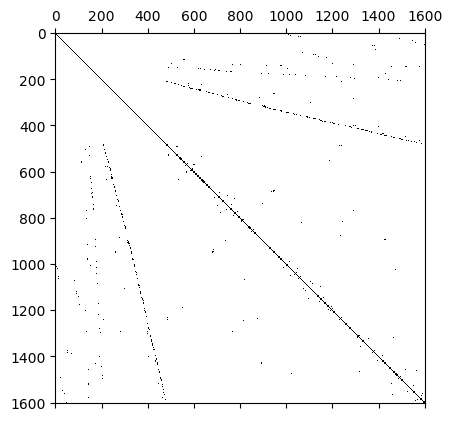

PyObject <matplotlib.image.AxesImage object at 0x7ff82de398d0>

In [42]:
# display non zero elements in the galerkin matrix
spy(m)

In [43]:
# Assemble right hand side
v=TipiFEM.vector_assembler(l, msh, basis, dofh)
v[1:10]

10-element Array{Float64,1}:
 0.0178548 
 0.0185706 
 0.0192417 
 0.0192668 
 0.0154429 
 0.0137188 
 0.0119054 
 0.00983874
 0.00740776
 0.00465635

In [44]:
v=TipiFEM.vector_assembler(l, msh, basis, dofh)
μ = m\v

1601-element Array{Float64,1}:
  0.375187 
  0.382202 
  0.44203  
  0.393674 
  0.353827 
  0.327022 
  0.292828 
  0.250822 
  0.201635 
  0.146633 
  0.087617 
  0.0266895
 -0.0338167
  ⋮        
 -0.0833418
 -0.027627 
 -0.177981 
 -0.134151 
 -0.198879 
 -0.236554 
 -0.214143 
 -0.196242 
 -0.175279 
 -0.238819 
 -0.21334  
 -0.253569 

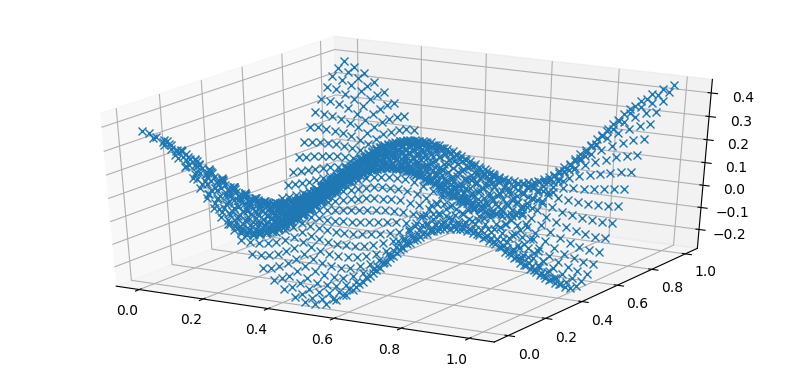

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7ff82dc99d90>

In [45]:
# todo: missing constant somewhere. values are to low
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d")
ax[:plot](map(x->x[1], image(msh.nodes)), map(x->x[2], image(msh.nodes)), μ, "x")